<h1 align="center"> Text Analysis </h1>

---

In this notebook we are going to dive fully into the text analysis part of this project. This includes implementation of Term Frequency-Inverse Document Frequency (TF-IDF) and it's application to generate wordclouds. Additionally, we will also dive into two methods of sentiment analysis. Namely, the dictionary-based approached LabMT and the dictionary- and rule-based approach VADER. These approaches will be utilized and compared when doing sentiment analysis on the characters wiki-pages and dialogue in the show. Finally, we will compute a lexical dispersion plot in order to gain insights in whether the theme of the story changes throughout the show.

How the data is extracted and pre-processed is described in section 2.1.1 *Data extraction, cleaning and preprocessing* in the Explainer Notebook.

We will begin by importing the nescarry packages and loading in the data.


In [1]:
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt 
import urllib
import json
import re 
import os 
import string
import itertools
import pandas as pd

from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests

import nltk
from nltk import FreqDist
from nltk.text import TextCollection
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from nltk.draw.dispersion import dispersion_plot
from matplotlib import pylab

#Download NLTK stuff for lemmatizer and tokenizer:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download("stopwords")

# For extracting and showing web images
from bs4 import BeautifulSoup
import urllib
from skimage import io


#Set stuff for nice formmatting of plots: 
import seaborn as sns
sns.set()
%matplotlib inline

# Include character names in list of stopwords
char_list = [f.split('.txt')[0] for f in os.listdir("/work/got_cleaned/")]

char_names = []
for char in char_list:
    char = char.lower()
    char_names.append(char.replace("_"," "))
    char_names.extend(char.split('_'))
stop_words = set(stopwords.words('english') + list(string.punctuation) + list(char_names))



/shared-libs/python3.7/py/lib/python3.7/site-packages/nltk/draw/__init__.py:15: UserWarning: nltk.draw package not loaded (please install Tkinter library).
  warnings.warn("nltk.draw package not loaded (please install Tkinter library).")
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Before loading in the text data from the character wiki-pages, we define a helper function to do some minor data-preprocessing for computation of TF-IDF. First, all text is set to lower case, then the text is tokenized, stop words are removed from the tokenized text and finally the text is lemmatized, i.e. different inflections of the same word are grouped together to a single word. Here, it should be noted that we have included the character first and last names in the stopwords list as these do not relay any interesting information about characters, allegiance or sentiment.

In [3]:
# Helper function to do some minor datapreprocessing: set all text to lower, tokenize text, remove stop words and lemmatization
def clean_text(txt):    
    txt = txt.lower()

    word_tokens = wordpunct_tokenize(txt)
    
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]


    wnlet = WordNetLemmatizer()
    words = [wnlet.lemmatize(w) for w in filtered_sentence] 
    return words

The dialogue data is loaded in:

In [5]:
#### Dialogue of characters

resp = requests.get("https://raw.githubusercontent.com/jeffreylancaster/game-of-thrones/master/data/script-bag-of-words.json")

diag = json.loads(resp.text)

char_diag = {}
for element in diag:
    episode = element['episodeNum']
    season = element['seasonNum']
    title = element['episodeTitle']
    text = element['text']
    for textObj in text:
        if textObj['name'] in char_diag:
            char_diag[textObj['name']].append(textObj['text'])
        else:
            char_diag[textObj['name']] = [textObj['text']]
            

The wiki page text data is loaded into a dictionary with all characters as dictionary keys. The text data is first preprocessed by the helper function `clean_text`.

In [4]:
#### Create dictionary of characters and their wiki-page text

char_pages = {}
characters = [f.split('.txt')[0] for f in os.listdir("/work/got_cleaned/")]

for char in characters:
    name = char.replace('_', ' ')
    with open('/work/got_cleaned/'+char+".txt", "r", encoding = "utf-8") as text_file:
            txt = text_file.readlines()

    txt = clean_text("".join(txt))
    char_pages[name] = txt

<h2 align ="center"> 1. Wordclouds

---

<h3 align="center"> 1.1 Term Frequency-Inverse Document Frequency </h3>

We will begin by defining the term frequency term for a given word: Number of times the word occours in the text divided by total number of words in the text. For the inverse document frequency term: $\text{log}\left(\dfrac{N}{df_i} \right)$ where N is the number of documents and $df_i$ is the document frequency of a given word. In our case, we want to compute the TC-IDF for four different sets of documents; namely, for the dialogue, the characters, the allegiances, and for a given season in the show.

We will start by computing the TF-IDF for the character dialogues. This is done by first computing the term count of every character document, i.e. dialogue, and in order to convert these term count to frequencies later on, the total word count of the document as well. This step can be seen below.



In [6]:
#TF-IDF for 
#Create space for dict:
tc_dict_char = {}
l_dict_char = {}

# List of characters
char_list = [f.split('.txt')[0] for f in os.listdir("/work/got_cleaned/")] # list of all characters

# Iterate through all characters
for char_key in char_list:
    try:
        words = char_diag[char_key.replace("_", " ")] #extract dialogue for given character
        words = " ".join(words)
    except:
        continue
    words = clean_text(words)

    #Total word count for given character
    l_dict_char[char_key] = len(words)

    #Compute TC for the tokens in character document
    tc_dict_char[char_key] = FreqDist(words)

Now, the IDF can be computed. In order to compute the document frequency of a given word, $df_i$, we first find all unique words in all character documents. Then, using the formula stated above for IDF, we compute the IDF. In this case, we have 137 unique documents, N, and simply count, for every unique word, in how many of these documents a given word occour. 

In [7]:
# Find all unique words
unique_words = set(list(itertools.chain(*tc_dict_char.values())))

# Calculate idf
idf = {word: 
            #Find in how many documents that each word is present:
            np.log(len(tc_dict_char) / sum([tf[word] > 0 for k, tf in tc_dict_char.items()])) 
            #Iterate through unique words:
            for word in unique_words
      }

Finally, we can compute the TF-IDF for the character dialogue as seen below. In order to convert the before computed term counts to term frequencies, we simply divide the TC with the computed total word count of the given document as well.

In [8]:
#Create dict for tf-idf values:
tf_idf_char = {}

#Iterate through communities:
for char in tc_dict_char.keys():
    tf_idf = {}
    #Iterate through each word in each community:
    for word, tc_value in tc_dict_char[char].items():
        #Extract IDF
        idf_value = idf[word]
        #Compute TF-IDF
        tf_idf[word] = idf_value*tc_value/l_dict_char[char]
    tf_idf_char[char] = tf_idf    

The same approach is taken when computing the TF-IDF for the character pages. In this case we have 163 documents.

In [9]:
#hide
def tf_idf_func(char_dict, char_list): 
    #Create space for dict:
    tc_dict_char = {}
    l_dict_char = {}

    #Iterate through the characters
    for char in char_list:
        # Error handling as not all characters have a wiki page
        try:
            words = char_dict[char.replace("_", " ")]
        except:
            continue

        #Total word count for given character
        l_dict_char[char] = len(words)
        #Compute TC for the community words:
        tc_dict_char[char] = FreqDist(words)

    # Find all unique words
    unique_words = set(list(itertools.chain(*tc_dict_char.values())))

    # Calculate idf
    idf = {word: 
                #Find in how many documents that each word is present:
                np.log(len(tc_dict_char) / sum([tf[word] > 0 for k, tf in tc_dict_char.items()])) 
                #Iterate through unique words:
                for word in unique_words
        }

    #Create dict for tf-idf values:
    tf_idf_char_page = {}

    #Iterate through characters:
    for char in tc_dict_char.keys():
        tf_idf = {}
        #Iterate through each word in each character document:
        for word, tf_value in tc_dict_char[char].items():
            #Extract IDF
            idf_value = idf[word]
            #Compute TF-IDF
            tf_idf[word] = idf_value*tf_value/l_dict_char[char]
        tf_idf_char_page[char] = tf_idf    
    return tf_idf_char_page

tf_idf_char_page = tf_idf_func(char_pages, char_list)

Now, for the third set of documents we want to investigate, namely for the different allegiances, we first have to compile documents for all the different allegiances. When we created the overall Game of Thrones network, one of the saved attributes were allegiance. This is therefore utilized in order to compile this set of documents. All character documents from the dialogue of the same allegiance is pooled into one single document for the given allegiance. Otherwise, the approach is the same of the previous.

In [10]:
#### TF-IDF allegiance:
# Load in network
G = nx.read_gpickle("/work/got_G.gpickle")

# List of allegiances for all characters
allegiances = list([allegiance for char, allegiance in  nx.get_node_attributes(G, "allegiance").items() if allegiance != ""])

# Value count of the different allegiances
allegiances = [[allegiances.count(att),att]for att in set(allegiances) if att != ""]

# Select 6 largest allegiances
chosen = sorted(allegiances, key = lambda i: i[0], reverse = True)[:6]

# List of all unique allegiances
allegiances = list(set([allegiance for char, allegiance in  nx.get_node_attributes(G, "allegiance").items() if allegiance != ""]))
l_dict_al, tc_dict_al = {}, {} # initialize dicts
for allegiance in allegiances: # iterate through the allegiances
    words = []
    for char, a2 in nx.get_node_attributes(G, "allegiance").items(): # Iterate through the characters and their respective allegiance
        if a2 == allegiance:
            try:
                words.extend(char_diag[char.replace("_", " ")])
            except:
                continue
    
    words = clean_text(" ".join(words))
    
    #Total word count for given character
    l_dict_al[allegiance] = len(words)
    #Compute TC for the community words:
    tc_dict_al[allegiance] = FreqDist(words)

And the same approach is then taken as previous when computing the TF-IDF.

In [11]:
# Find all unique words
unique_words = set(list(itertools.chain(*tc_dict_al.values())))

# Calculate idf
idf_al = {word: 
            #Find in how many documents that each word is present:
            np.log(len(allegiances) / sum([tf[word] > 0 for k, tf in tc_dict_al.items()])) 
            #Iterate through unique words:
            for word in unique_words
      }
#Create dict for tf-idf values:
tf_idf_al = {}

#Iterate through communities:
for allegiance in allegiances:
    tf_idf = {}
    #Iterate through each word in each community:
    for word, tf_value in tc_dict_al[allegiance].items():
        #Extract IDF
        idf_value = idf_al[word]
        #Compute TF-IDF
        tf_idf[word] = idf_value*tf_value/l_dict_al[allegiance]
    tf_idf_al[allegiance] = tf_idf   


Finally, the TF-IDF will now be computed for the last set of documents, namely the seasons. Here, we pool the documents of all characters present in a given season. 

In [12]:
## Wordcloud based on season: 
char_season_wiki = {}
base_path = "/work/got2/s"
for s in range(1,9):
    txt = []
    files = os.listdir(base_path + str(s)+"_cleaned/")
    for file in files:
        with open('/work/got2/s'+str(s)+"_cleaned/"+ file, "r", encoding = 'utf-8') as text_file:
                tmp = text_file.readlines()
        txt.extend(tmp)
    char_season_wiki["s"+str(s)] = clean_text(" ".join(txt))


tf_idf_season = tf_idf_func(char_season_wiki,['s'+str(i) for i in range(1,9)])

<h3 align="center"> 1.2 Character Wordclouds </h3>

As we now have three datasets with computed TF-IDF scores, we need a good way to present the results, and we have chosen to use Wordclouds as a way to present the TF-IDF scores. The words are then scaled in size based on the TF-IDF score, and by that we can easily see the frequent used words, and try to see if we can understand the characters and allegiances better by investigating these results. 

In the first prart we will look at the character wordclouds and compare these between the character dialogoue and the wiki-pages. To set the scene we have also included the character image. 

We first define two functions which is used to retrieve the image from the character page. We are using `BeautifulSoup` to scrape the character wiki-page for the thumbnail image.

In [13]:
def getdata(url):
    """
    Function retrieves the data on the character page
    """
    r = requests.get(url)
    return r.text
def get_img(name):
    """
    Uses the retrieved information to find the thumbnail image, by scraping the charater page
    """
    htmldata = getdata("https://gameofthrones.fandom.com/wiki/"+name)
    soup = BeautifulSoup(htmldata, 'html.parser')
    image = soup.find('img', attrs={"class":"pi-image-thumbnail"})
    return image['src']

Next, we are setting up af function to create the visualization displaying both the character image, Wordclouds based on character dialogoue and character wiki-page. Which can be seen below. We have updated some of the stats for the wordclouds ie. the color maps, sizes to make them more appealing. 

In [14]:
# Wordclouds based on character pages and compare with dialogoue
def plot_wordcloud_characters(selected_char, tf_idf_char_pages, tf_idf_diag):
    """
    Function to display wordclouds of selected characters 
    Displays the character image, wordclouds based on dialogoue and character wiki-page

    """
    #Setup figure:
    plt.figure(figsize=(20,25))

    #Set colours
    color_lst = ['Blues','Purples','autumn','rocket','spring_r']

    #The figure has three index: 1. image, 2. wordcloud (Wiki-page) 3. wordlcoud (dialogoue)
    plot_idx = 1
    i = 0

    #Iterate through characters 
    for char in selected_char:
        word_list = [] 
        #Extract words for wiki-page
        for word, value in tf_idf_char_pages[char].items():
            word_list.append((word+' ')*int(np.ceil(value)))
        word_list = " ".join(word_list)

        #Generate wordcloud
        wc_char_pages = WordCloud(collocations = False, background_color='black', 
                                    colormap=color_lst[i], width = 400, height = 450).generate(word_list)

        word_list = []
        #Do the same for dialogoue
        for word, value in tf_idf_diag[char].items():
            word_list.append((word+' ')*int(np.ceil(value)))
        word_list = " ".join(word_list)
        wc_char_diag = WordCloud(collocations = False,background_color='black',
                                    colormap=color_lst[i], width = 400, height = 450).generate(word_list)

        #Visualize figure:
        plt.subplot(5,3,plot_idx)
        url = get_img(char)
        img = io.imread(url)
        plt.imshow(img, extent = [0,5,0,6], aspect = 1)
        plt.axis("off")
        plot_idx += 1

        plt.subplot(5,3,plot_idx)
        plt.imshow(wc_char_pages, interpolation='bilinear')#extent = [0,6,0,6], aspect = 1

        if plot_idx == 2:
            plt.title("From Wiki Page", fontsize = 40, color = 'black')
        plt.axis("off")

        plot_idx += 1
        plt.subplot(5,3,plot_idx)
        plt.imshow(wc_char_diag, interpolation='bilinear')#, extent = [0,6,0,6], aspect = 1
        
        if plot_idx == 3:
            plt.title("From Character \nDialogoue", fontsize = 40, color = 'black')
        plt.axis("off")
        plot_idx += 1
        i += 1

    plt.margins(x=0, y = 0)
    plt.tight_layout()
    plt.show()


We have selected the characters: [Jon Snow](https://gameofthrones.fandom.com/wiki/Jon_Snow), [Arya Stark](https://gameofthrones.fandom.com/wiki/Arya_Stark), [Bronn](https://gameofthrones.fandom.com/wiki/Bronn), [Brienne of Tarth](https://gameofthrones.fandom.com/wiki/Brienne_of_Tarth) and [Jaime Lannister](https://gameofthrones.fandom.com/wiki/Jaime_Lannister), and we are going to look at these wordclouds. The wordclouds are generated using the builtin function `WordCloud`, which makes it easy to create nice visualizations.

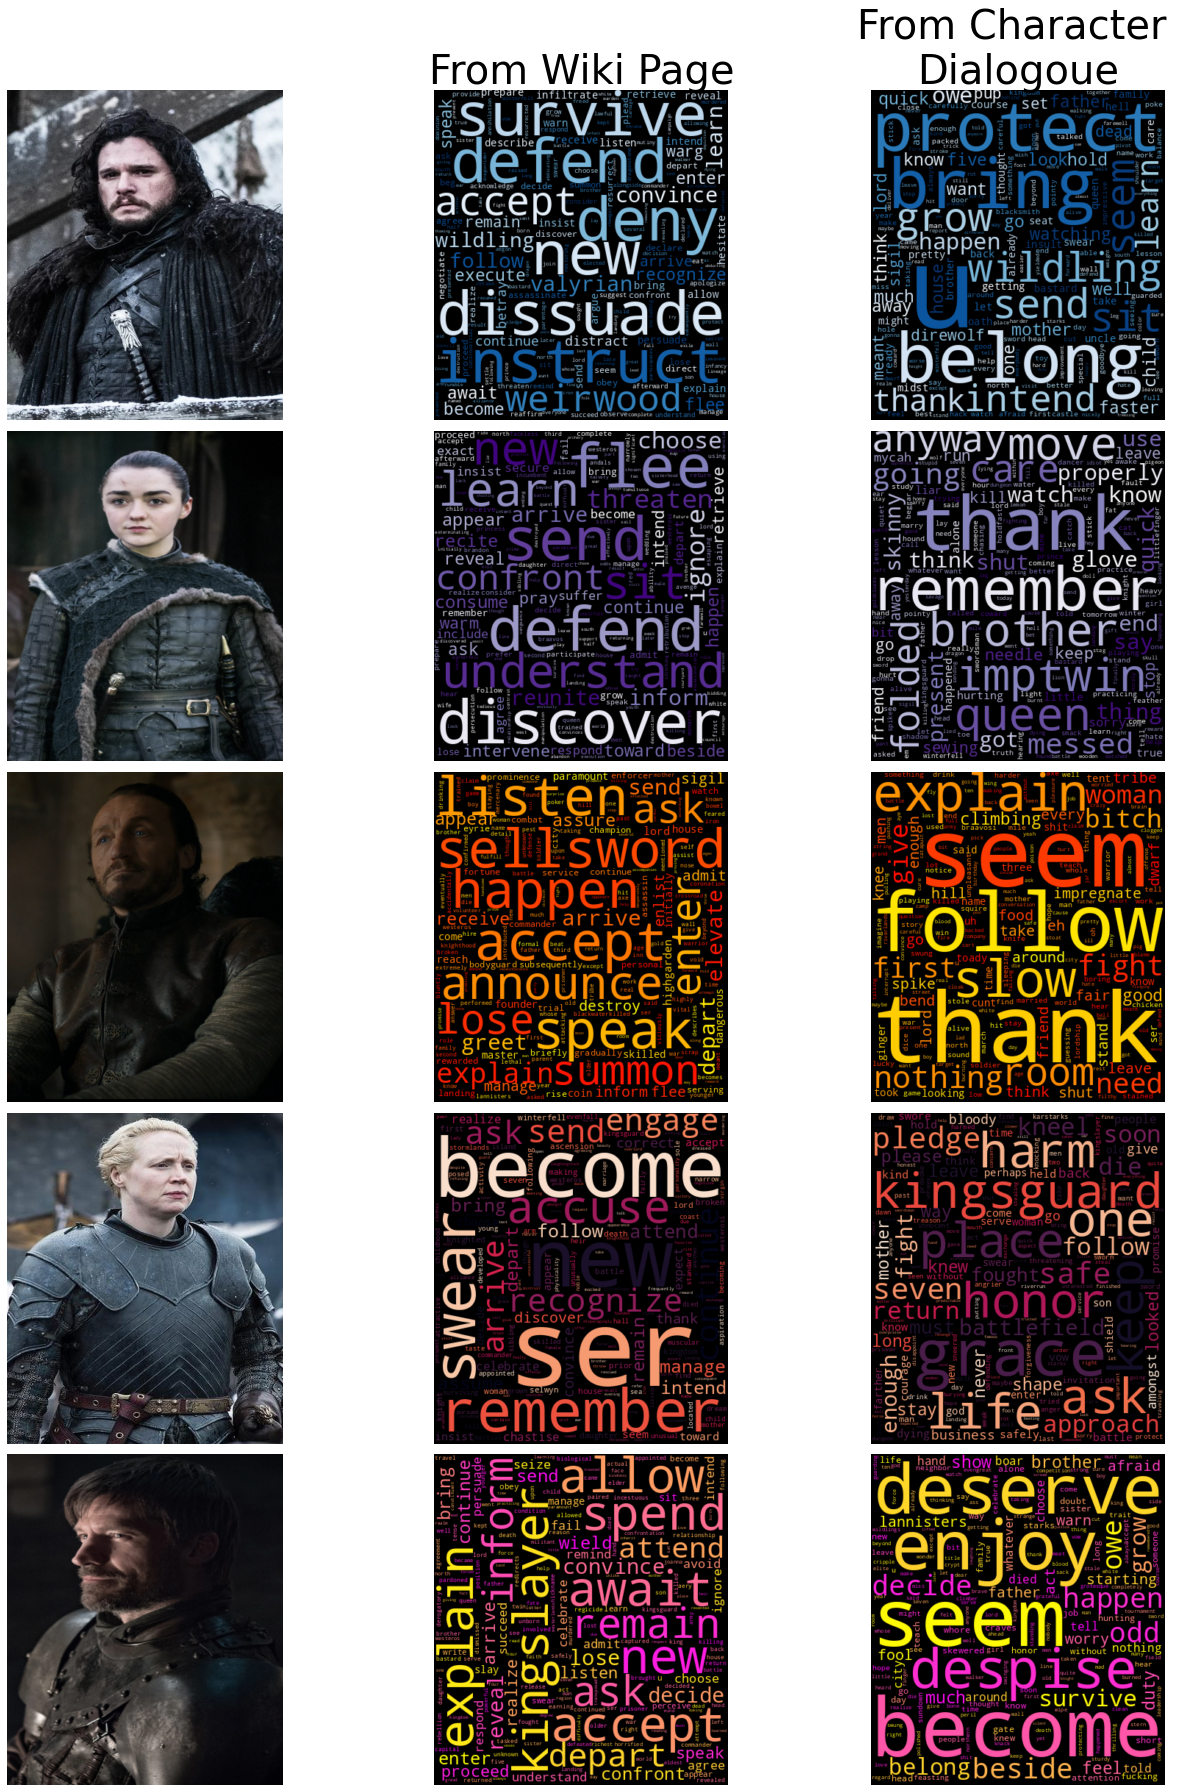

In [ ]:
selected_characters = ['Jon_Snow','Arya_Stark','Bronn','Brienne_of_Tarth','Jaime_Lannister']
plot_wordcloud_characters(selected_characters,tf_idf_char_page,tf_idf_char)


If we llok at Bronn we can see from the wiki-page that the word with highest score is sellssword, and follow with respect to the dialogoue, which are very well describing words of him. He follows Tyrion Lannister, and are a sellsword. If we look at Brienne of Tarth, she becomes part of Renly Baratheons Kingsguard, and she swears to protect multiple persons in the story here including Renly and Catelyn.

When comparing the generated wordclouds for the respective data sets it should be noted, that the same words are, for the most part, not present for the respective characters. This is expected as one would imagine that the text from the characters wikipedia pages are more descriptive of the character and their place in the story whereas the wordcloud from the dialogoue is exactly that; their most descrriptive words according to TF-IDC used throughout the series. This would be interesting to compare with sentiment analysis which is the second part of this page. 


<h3 align="center"> 1.3 Allegiance Wordclouds </h3>

As described above we have pooled the TF-IDF scores for the characters present in a allegiance. For this, we have selected the houses: Stark, Lannister, Targaryen, Greyjoy and the independent group The Night's Watch. It would be interesting to see, if the houses mottos would appear in these word clouds. The respective house mottos are:

<h5 align="center"> House Stark: Winter is coming <br>
House Lannister: Hear Me Roar! <br>
House Targaryen: Fire and Blood <br>
House Greyjoy: We Do Not Sow <br> <br>
</h5>

As the Night's Watch is not a House but rather a brotherhood sworn to protect The Wall, they do not have a motto.

We have created a function to plot the mottos, again using `BeautifulSoup` to extract the thumbnail images of the house logos, and `WordCloud` function to create the wordclouds. The result can be seen below.

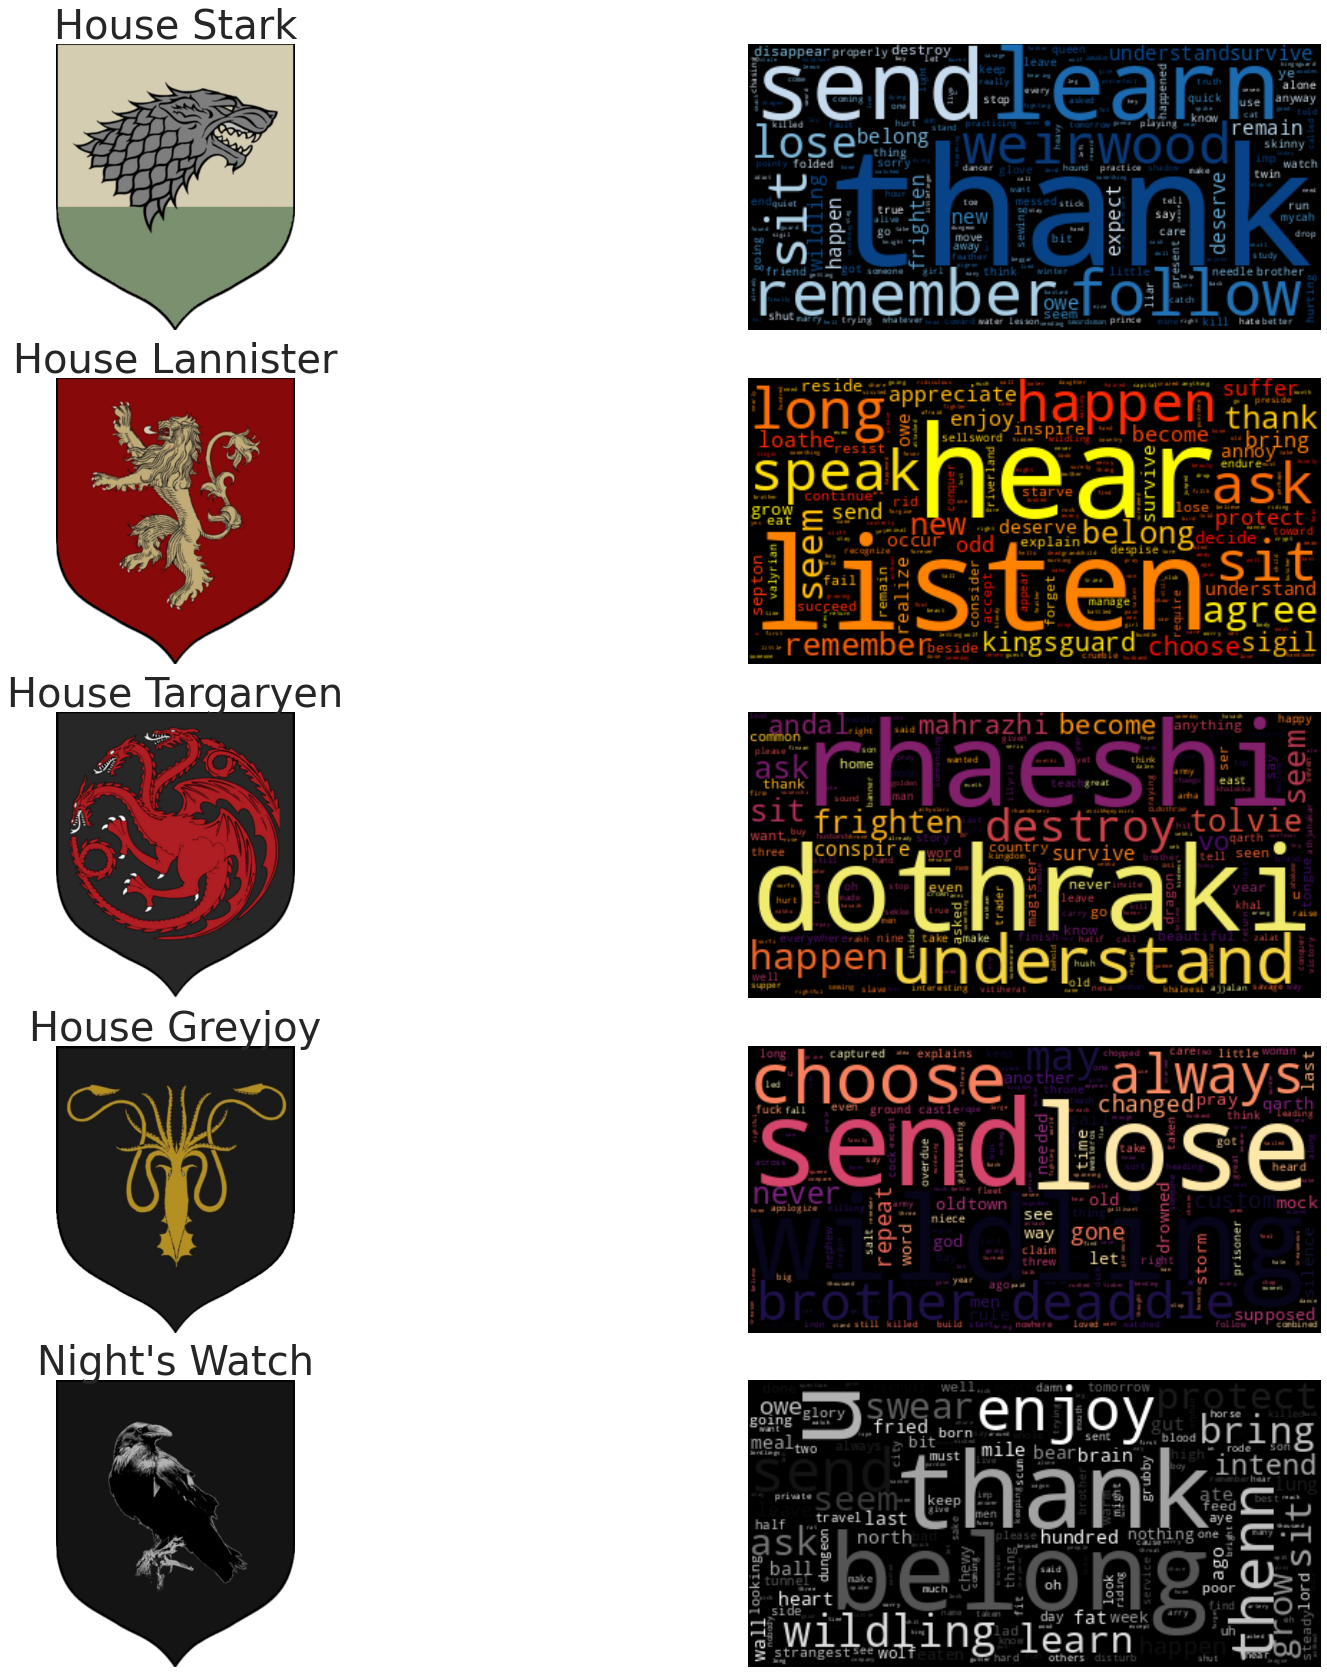

In [15]:
# Wordclouds of allegiance
def plot_wordcloud_allegiance(selected_al, tf_idf_al):
    plt.figure(figsize=(24,28))

    color_lst = ['Blues','autumn','inferno','magma_r','Greys']
    i = 0
    plot_idx = 1
    for allegiance in selected_al:
        word_list = [] 
        for word, value in tf_idf_al[allegiance].items():
            word_list.append((word+' ')*int(np.ceil(value)))
        word_list = " ".join(word_list)
        wc_char_al = WordCloud(collocations = False, background_color='black',
                                colormap=color_lst[i]).generate(word_list)

        plt.subplot(6,2,plot_idx)
        url = get_img(allegiance.replace(" ","_"))
        img = io.imread(url)
        plt.imshow(img, extent = [0,5,0,6], aspect = 1)
        plt.axis("off")
        plt.title(allegiance, fontsize = 40)
        plot_idx += 1

        plt.subplot(6,2,plot_idx)
        plt.imshow(wc_char_al, interpolation='bilinear')#,extent = [0,6,0,6], aspect = 1)
        plt.axis("off")
        plot_idx += 1
        i += 1



    plt.tight_layout()
    plt.show()

selected_al = ['House Stark','House Lannister','House Targaryen','House Greyjoy','Night\'s Watch']
plot_wordcloud_allegiance(selected_al, tf_idf_al)

When looking at the wordclouds above and the respective house mottos, only the Lannisters' *Hear* (big, middle) are present. All the wordclouds are, however, very descriptive of the respective houses. For instance for the Night's Watch, a military order sworn to protect The Wall, words like *protect*, *wildling* and *swear* are present. The same can be said for House Targaryan, where the main Targaryan character, Daenerys, is married to a dothraki warlord and later in the show, is a leader of dothraki people herself. 

<h3 align="center"> 1.4 Season Wordclouds</h3>

One of our goal insights that we want to investigate in this text analysis section is to understand whether the overall theme of the Game Of Thrones series changes season by season. One way we want to investigate this is by looking at the wordclouds for each season, again with word size based on the TF-IDF score. By this we can get indication of the important words in the given season and hopefully understand what is the overarching theme in each season. We have again created a function to plot these wordclouds again utilzing the `WordCloud` functionality. 

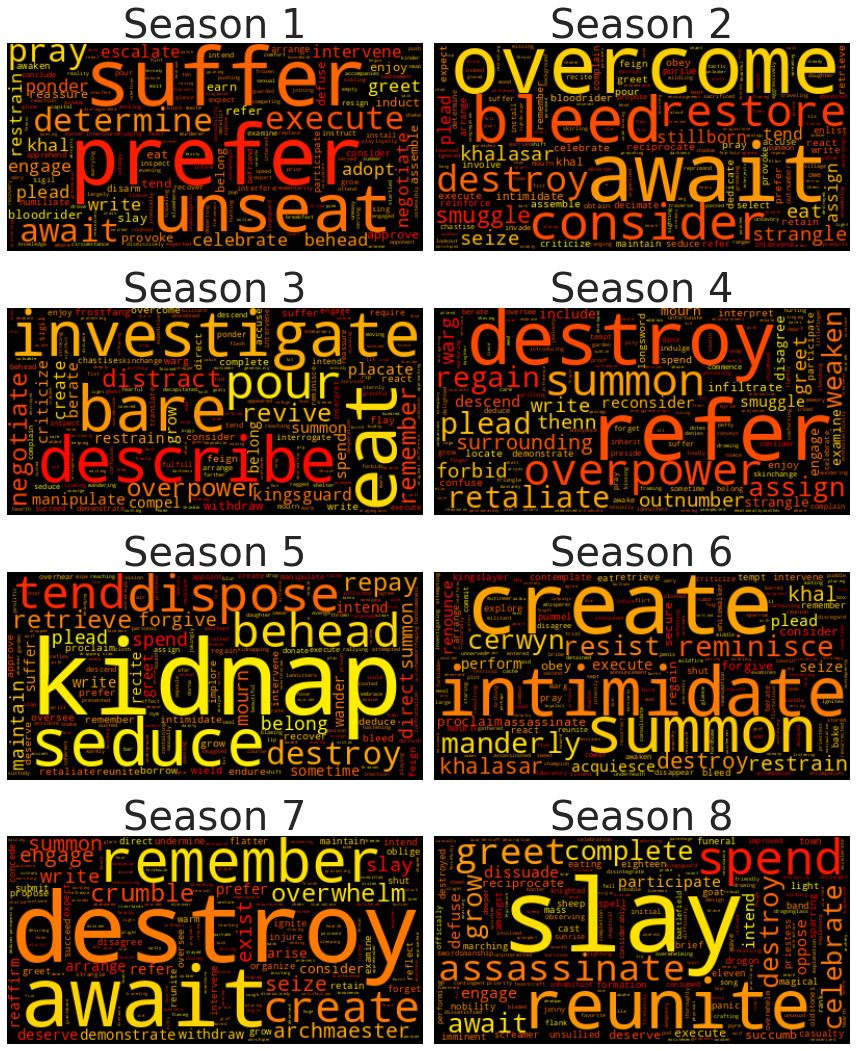

In [16]:
def plot_wordcloud_season(seasons,tc_idf):
    plt.figure(figsize = (12,15))
    for i,season in enumerate(seasons):
        word_list= []
        for word, value in tc_idf[season].items():
            word_list.append((word+' ')*int(np.ceil(value)))
        word_list = " ".join(word_list)
        wc = WordCloud(collocations=False, background_color='black',
                        colormap='autumn_r').generate(word_list)

        plt.subplot(4,2,i+1)
        plt.imshow(wc, interpolation='bilinear')
        title = "Season {}".format(i+1)
        plt.title(title, fontsize = 40)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_wordcloud_season(["s"+ str(i) for i in range(1,9)], tf_idf_season)

Taking example in the wordclouds generated for season 1 & 8, the emphasized words seem very descriptive of their respective seasons. Starting with season 1:
- *execute, behead* : One of the main acts of season 1, is the execution of Lord Eddard Stark, the head of House Stark. He is, by the unexpected command of the king Joffrey Baratheon, beheaded in the middle of King's Landing.
- *Khal, bloodrider* : Another of the main story arcs, is the story of Daenarys Targaryan which takes place in a foreign land. In season 1, Daenarys is married of to a powerful Khal, Khal Drogo, in a trade by Daenarys brother. A Khal has three bloodriders who are to live and die by the life of their Khal. The words *Khal* and *bloodrider* being so prominent makes sense, as they are key roles in Daenarys' story arc.

Comparing the wordclouds of season 1 and season 8, it appears season 8 has different key words. For season 8:
- *celebrate* : The word *celebrate* stands in stark constrast to the prominent words *suffer* from season 1. This could be due to season 8 being the series final season and it's characters are therefore celebrating the story ending on a happy note (for some of the characters :wink: )
- *reunite* : The story culminates in the final season, many characters who have been seperated throughout the show are finally reunited in the final season of the show, hence emphasis on the word *reunite* makes sense. 

It should also be noted that the word *destroy* is present in the majority of the wordclouds, only being omitted in the wordclouds for season 1 and 3.

<h2 align="center"> 2. Sentiment Analysis </h2>

---

In this part of the text analysis, we will now do sentiment analysis. This will be done on both the characters wiki-pages but also their dialogue. Additionally, sentiment analysis will also be done across the different seasons of the Game of Thrones. 

<h3 align="center"> 2.1 Dictionary- and Rule-based sentiment analysis </h3>

For sentiment analysis in this project, we will make use of two methods: namely, LabMT and VADER. Both of these methods utilize a dictionary-based method. Simply put, both approaches utilizes a dictionary of sentiment laden words. The sentiment laden words have been given a score depending on the judged sentiment of the word. VADER imposes an additional method: rule-based. These rules were originally implemented to help asses the sentiment of sentences in social media. The rules help convey how degree adverbs can change the sentiment. Furthermore, VADER has also imposed rules to convey how punctuation and capitalization can change the sentiment of a given sentence. Due to VADER also taking degree adverbs, capitalzation and punctuation into account, this method expects whole sentences and stopwords havent been removed compared to LabMT which simply expects tokens. It should also be noted that the two methods score sentiment on a different scale. LabMT scores on a scale from 1 to 9 while VADER scores from -4 to 4. A score of 5 is considered neutral for LabMT while for VADER neutral is between -0.05 and 0.05. 

We will begin the sentiment analysis by defining some helper functions to utilize the LabMT and VADER sentiment analysers.


In [18]:
# Load in LabMT word look up data
LabMT = pd.read_table('/work/labMIT-1.0.txt', delimiter="\t")
#Convert LabMT to a dictionary:
LabMT_dict = {word : happiness_score for word,happiness_score in zip(LabMT['word'], LabMT['happiness_average']) }

#Load VADER wordlist:
analyzer = SentimentIntensityAnalyzer()

#Function to compute LabMT sentiment values of tokens:
lemmatizer = WordNetLemmatizer() 
def sentiment_LabMT(tokens):
    #Extract tokens that are present in LabMT:
    tokens_LabMT = [token for token in tokens if token in LabMT_dict.keys()]
    #Extract sentiment values of tokens:
    happiness_LabMT = [LabMT_dict[token] for token in tokens_LabMT]

    #Return mean values of sentiments for given tokens:
    return  np.mean(happiness_LabMT)

#Function to copmpute VADER sentiment values of a sentence:
def sentiment_VADER(tokens):
    
    happiness_VADER = [analyzer.polarity_scores(sentence)['compound'] for sentence in tokens]
    return np.mean(happiness_VADER)

And a function to plot the sentiment analysis results.

In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_VADER_LabMT_scores(char_sentiment_VADER,char_sentiment_LabMT, title,error_bar = False,
  com_sentiment_VADER_sd=None, com_sentiment_LabMT_sd=None, x_text = "Characters" ):
    # Create figure 
    fig = make_subplots(rows=1, cols=2)
    # Add traces

    if error_bar:
        fig.add_trace(
            go.Bar(x=[*char_sentiment_LabMT],
            y=list(char_sentiment_LabMT.values()), 
            error_y=dict(
            type='data', # value of error bar given in data coordinates
            array= list(com_sentiment_LabMT_sd.values()),
            visible=True),name="LabMT score"),
            row=1, col=1,
        )
        fig.add_trace(
            go.Bar(x=[*char_sentiment_VADER],
            y=list(char_sentiment_VADER.values()), 
            error_y=dict(
            type='data', # value of error bar given in data coordinates
            array= list(com_sentiment_VADER_sd.values()),
            visible=True),
            name="VADER score"),
            row=1, col=2,
        )
        
    else:
        fig.add_trace(
            go.Bar(x=[*char_sentiment_LabMT],
            y=list(char_sentiment_LabMT.values()), name="LabMT score"),
            row=1, col=1,
        )

        fig.add_trace(
            go.Bar(x=[*char_sentiment_VADER],
            y=list(char_sentiment_VADER.values()), name="VADER score"),
            row=1, col=2,
        )

    # Add figure title
    fig.update_layout(
        title_text=title
    )

    # Set x-axis title
    fig.update_xaxes(title_text=x_text)
    # Set y-axes titles
    fig.update_yaxes(title_text="<b>LabMT sentiment score</b>", row=1,col = 1)
    fig.update_yaxes(title_text="<b>VADER sentiment score</b> ", row = 1, col = 2)
    return fig


<h3 align="center"> 2.2 Sentiment analysis on characters' dialogue </h3>

We will now begin on the sentiment analysis. For this subsection, sentiment analysis will be done on the characters' dialogue. This is based on all dialogoue across all seasons as this is expected to give a better overview of each character sentiments. We start by loading in the dialogue data and compute the sentiment values using the before defined helper functions.


In [20]:
tokens_LabMT = {char : clean_text(" ".join(text)) for char, text in char_diag.items()}
tokens_VADER = char_diag    

files = os.listdir("/work/got/")
char_list = [file.split('.txt')[0] for file in files]

#Suprress warnings:
warnings.filterwarnings("ignore")
#Compute sentiment for each character:
char_sentiment_LabMT = {char :sentiment_LabMT(tokens_values) for char, tokens_values in tokens_LabMT.items() if char.replace(" ", "_") in char_list}
char_sentiment_VADER = {char :sentiment_VADER(tokens_values) for char, tokens_values in tokens_VADER.items() if char.replace(" ", "_") in char_list}

The found sentiment scores are then sorted in order to find which characters are the happiest and saddest. Here, we print the top 10 happiest and saddest characters.

In [21]:
#Sort and find the top 10 happiest and sadest:
happiest_VADER = sorted(char_sentiment_VADER, key = lambda i: char_sentiment_VADER[i],reverse = True)[:10]
happiest_LabMT = sorted(char_sentiment_LabMT, key = lambda i: char_sentiment_LabMT[i],reverse = True)[:10]

sadest_VADER = sorted(char_sentiment_VADER, key = lambda i: char_sentiment_VADER[i],reverse = False)[:10]
sadest_LabMT = sorted(char_sentiment_LabMT, key = lambda i: char_sentiment_LabMT[i],reverse = False)[:10]

print('Happiest based on VADER: ',happiest_VADER)
print('Happiest based on LabMT: ',happiest_LabMT)
print('Sadest based on VADER: ',sadest_VADER)
print('Sadest based on LabMT: ',sadest_LabMT)

Happiest based on VADER:  ['Dontos Hollard', 'Daisy', 'Pyat Pree', 'Harry Strickland', 'Olyvar', 'Mace Tyrell', 'Royal Steward', 'Margaery Tyrell', 'Matthos Seaworth', 'Marillion']
Happiest based on LabMT:  ['Alys Karstark', 'Daisy', 'Pyat Pree', 'Matthos Seaworth', 'Myrcella Baratheon', 'Lyanna Stark', 'Olyvar', 'Rhaegar Targaryen', 'Royal Steward', 'Trystane Martell']
Sadest based on VADER:  ['Anya Waynwood', 'Izembaro', 'Rorge', 'Hallyne', 'Rickard Karstark', 'Gregor Clegane', 'Leaf', 'Pypar', 'Syrio Forel', 'Obara Sand']
Sadest based on LabMT:  ['Gregor Clegane', 'Rakharo', 'Qotho', 'Pypar', 'Rickard Karstark', 'Grenn', 'Greatjon Umber', 'Sandor Clegane', 'Rast', 'Meryn Trant']


The figure below presents the sentiment of the 10 happiest and 10 sadest characters. To the left the sentiment are based on LabMT whereas the figure to the right is based on VADER. 

It should be noted that the two methods does not completely agree, but some characters are present in both results such as: *Daisy, Pyat Pree, Olyvar* and *Matthos Seaworth* are in top 10 of the happiest character in both results. Also some characters are present in both lists presenting the sadest characters such as *Gregor Clegane*. 

The happiest characters appear to be quite happy based on the VADER and LabMT score as the score only goes to 1 for VADER and 9 for LabMT and the same for saddest characters. 

In [22]:
sadest_VADER.reverse()
sadest_LabMT.reverse()

plot_dict_vader = {key: char_sentiment_VADER[key] for key in happiest_VADER+sadest_VADER}
plot_dict_LabMT = {key: char_sentiment_LabMT[key] for key in happiest_LabMT+sadest_LabMT}

fig = plot_VADER_LabMT_scores(plot_dict_vader, plot_dict_LabMT, title = "Sentiment analysis of character dialogoue")
fig.show()

<h3 align="center"> 2.3 Sentiment analysis on characters' wiki-page </h3>

We will now do sentiment analysis on the characters' wiki-pages. Similair as before, we start by loading in the text data and compute the sentiment values using the before defined helper functions.


In [23]:
characters = [f.split('.txt')[0] for f in os.listdir("/work/got_cleaned/")]
char_pages = {}

for char in characters:
    name = char.replace('_', ' ')
    with open('/work/got_cleaned/'+char+".txt", "r", encoding = "utf-8") as text_file:
            txt = text_file.readlines()
    char_pages[name] = txt

tokens_LabMT = {char : clean_text(" ".join(text)) for char, text in char_pages.items()}
tokens_VADER = char_pages

#Suprress warnings:
warnings.filterwarnings("ignore")
#Compute sentiment for each character with use of the before defined helper functions:
char_sentiment_LabMT = {char :sentiment_LabMT(tokens_values) for char, tokens_values in tokens_LabMT.items() }
char_sentiment_VADER = {char :sentiment_VADER(tokens_values) for char, tokens_values in tokens_VADER.items() }

Again, we sort the results and find the top 10 happiest and saddest characters.

In [24]:
#Sort and find the top 10 happiest and sadest:
happiest_VADER = sorted(char_sentiment_VADER, key = lambda i: char_sentiment_VADER[i],reverse = True)[:10]
happiest_LabMT = sorted(char_sentiment_LabMT, key = lambda i: char_sentiment_LabMT[i],reverse = True)[:10]

sadest_VADER = sorted(char_sentiment_VADER, key = lambda i: char_sentiment_VADER[i],reverse = False)[:10]
sadest_LabMT = sorted(char_sentiment_LabMT, key = lambda i: char_sentiment_LabMT[i],reverse = False)[:10]

print('Happiest based on VADER: ',happiest_VADER)
print('Happiest based on LabMT: ',happiest_LabMT)
print('Sadest based on VADER: ',sadest_VADER)
print('Sadest based on LabMT: ',sadest_LabMT)

Happiest based on VADER:  ['Kraznys mo Nakloz', 'Xaro Xhoan Daxos', 'Leaf', 'Septa', 'Moro', 'Missandei', 'Anguy', 'Lyanna Stark', 'Renly Baratheon', 'Matthos Seaworth']
Happiest based on LabMT:  ['Septa', 'Order of Maesters', 'Moro', 'Matthos Seaworth', 'Leaf', 'Margaery Tyrell', 'Selyse Baratheon', 'Marillion', 'Tycho Nestoris', 'Ros']
Sadest based on VADER:  ['Amory Lorch', 'Orell', 'Karl Tanner', 'Polliver', 'Rast', 'Ramsay Bolton', 'Joffrey Baratheon', 'Alliser Thorne', 'Randyll Tarly', 'Obara Sand']
Sadest based on LabMT:  ['Biter', 'Amory Lorch', 'Rorge', 'Polliver', 'Lommy', 'Orell', 'Qhono', 'Rast', 'Black Lorren', 'Gregor Clegane']


From the figure below it can be seen that the two methods, again, do not completely agree on the result but both methods yield approximately the same result. Again the figure displays the 10 happiest and sadest characters based on LabMT and VADER.

At a first glance, it is noticed that the VADER score are lower for the happiest characters than in the previous part whereas the sadest achieve almost the same score. The LabMT results are quite similar in sentiment levels. 
Again many characters are found in both results such as *Septa, Moro, Orell* and *Polliver*. 

When comparing with the result based on the character dialogoue not many characters are found in all four results. This could indicate that the wiki-pages and dialogoue does not contain the same information, or that the chosen words on the wiki-pages do not necessarily imply information about the characters sentiment. 

It would be expected that the dialogoue contains greater variety of words that can explain the character mood, whereas the wiki-pages would contain words that describe the character and his/hers actions. We also notice that the variation in VADER sentiment scores are far greater when using the dialogoue compared with the wiki-page which could be an indication that our hypothesis are true. 

In [25]:
sadest_VADER.reverse()
sadest_LabMT.reverse()
plot_dict_vader = {key: char_sentiment_VADER[key] for key in happiest_VADER+sadest_VADER}
plot_dict_LabMT = {key: char_sentiment_LabMT[key] for key in happiest_LabMT+sadest_LabMT}
fig = plot_VADER_LabMT_scores(plot_dict_vader, plot_dict_LabMT, title ="Sentiment analysis of character wiki-page" )
fig.show()

<h3 align = "center" > 2.4 Sentiment analysis on the series' seasons</h3>

As a last element in our sentiment analysis we are going to dive into the sentiment of each season. This could help us investigate whether the general mode changes in each season. Using same approach as before, we start by loading in the data.

In [26]:
char_season_wiki = {}
base_path = "/work/got2/s"
for s in range(1,9):
    txt = []
    files = os.listdir(base_path + str(s)+"_cleaned/")
    for file in files:
        with open('/work/got2/s'+str(s)+"_cleaned/"+ file, "r", encoding = "utf-8") as text_file:
                tmp = text_file.readlines()
        txt.extend(tmp)
    char_season_wiki["s"+str(s)] = clean_text( " ".join(txt))

The sentiment scores are then computed.

In [27]:
tokens_LabMT = {char : text for char, text in char_season_wiki.items()}
tokens_VADER = char_season_wiki

#Suprress warnings:
warnings.filterwarnings("ignore")
#Compute sentiment for each character:
char_sentiment_LabMT = {char :sentiment_LabMT(tokens_values) for char, tokens_values in tokens_LabMT.items() }
char_sentiment_VADER = {char :sentiment_VADER(tokens_values) for char, tokens_values in tokens_VADER.items() }

The figure below shows the sentiment of each season based on LabMT and VADER methods. When looking at the LabMT it can be seen that all season are approximately neutral, whereas the VADER scores are just to the sad side of the spectrum. Further, it is noticed that season 4 are the sadest whereas season 6 are the "happiest" when comparing them. 

In season 4 a lot of the semi-main characters die such as Prince Oberyn, Joffrey Baratheon, Shay, Tywin Lannister and the Mountain (Gregor Clegane) are transformed into the Monster version of himself. Which could explain why this season is saddest according to the sentiment analysis. 

In [28]:
fig = plot_VADER_LabMT_scores(char_sentiment_VADER, char_sentiment_LabMT, title = "Sentiment analysis of seasons",x_text = 'Season')
fig.show()

<h2 align="center"> 3. Lexical Dispersion Plot </h2>

---


We have already attempted to investigate how the theme changes season by season in Game Of Thrones by investigating the wordclouds for each season. As we want to investigate this a little further, we have also looked into lexical dispersion plot. Here we carefully selected a few words, which we expect to help us dive further into the changing theme of the series. Through the use of the lexical dispersion we expect to see how the theme changes by the change in frequency of the selected words season by season. 

First, we to set up the data in the correct order. We are again using the character dialogoue data for this, as we want to investigate the words that the characters use and thereby the theme in the series changes. We are going to tokenize the words, remove stopwords and lemmatize the words before saving them in a dictionary. The dictionary contains the season number as keys and values are the words used in the season. 

In [29]:
season_words = {}

#Set-up lemmatizer
wnlet = WordNetLemmatizer()

#Iterate through seasons
for s in range(1,9):
    season_words[s] = []
    for obj in diag: #Iterate through all object in dialogoue
        if obj['seasonNum'] == s: #Only use elements from the correct season

            #Get text 
            words = [sentence['text'] for sentence in obj['text']]

            #Tokenize, remove stopwords, lemmatize words:
            word_tokens = wordpunct_tokenize(" ".join(words))    
            filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
            filtered_sentence = [w for w in filtered_sentence if w != "..."]
            words = [wnlet.lemmatize(w.lower()) for w in filtered_sentence]

            #Save the words:
            season_words[s].extend(words)

As the `dispersion_plot` function by `nltk` does not allow custom x-ticks we have modified the original function to handle this. Further, we have modified the function so the default grid-lines in the horizontal direction better illustrates when a season ends and stops. This now allows us to display how the selected words are used season by season, and hopefully makes it easier to grasp. 

In [ ]:
def dispersion_plot(text, words, xticks = None, xlabels = None, lines = None):
    '''
    We have modified the dispersion plot function by NLTK to include custom x-ticks, so we can display how
    the use of selected words changes through the series.
    Further we have changed the default lines created by sns.set(), to better display when one season stops and another starts.
    '''
    text = list(text)
    words.reverse()

    points = [
        (x, y)
        for x in range(len(text))
        for y in range(len(words))
        if text[x] == words[y]
    ]
    if points:
        x, y = list(zip(*points))
    else:
        x = y = ()

    #Add vertical lines
    if lines is not None: 
        for l in lines:
            pylab.plot([l,l], [-1,len(words)], color = 'white')
    #Plot the points
    pylab.plot(x, y, "b|", scalex=0.1, markersize = 12)
    #Y-ticks ( ie. words)
    pylab.yticks(list(range(len(words))), words, color="b", fontsize = 12)
    pylab.ylim(-1, len(words))
    pylab.title("Lexical Dispersion Plot", fontsize = 20)
    pylab.xlabel("Season offset", fontsize = 12)
    #Add x-tciks
    if xticks is not None:
        pylab.xticks(ticks=xticks, labels=xlabels, rotation = '45', fontsize = 12)
    plt.tight_layout()
    plt.grid(axis = 'x')
    pylab.show()

We will start out by defining the x-ticks and their location which we do by iterating through our `season_word` dict and defining the location of the x-ticks as the center of this season. The season length are defined by the number of words in this season. Therefore the length can vary based on the length of the dialogoue. Further, we save the end/start of each season so we can draw vertical lines here when plotting. 

In [ ]:
#Extract all words across seasons for dispersion plot
all_words = []
for words in season_words.values():
    all_words.extend(words)

ticks = []
labels = []
vert_line = [0]
tmp = 0
#Get x-tick position, labels and vertical line positions
for i, (key, value) in enumerate(season_words.items()):
    ticks.append(int(np.round((tmp +  (tmp+len(value)))/2)))
    labels.append('Season ' + str(key))
    tmp += len(value)
    vert_line.append(tmp)

We are now ready to visualize how the words develop across the series and the selected words are: 

*white* and *walker* as we want to investigate how often white walkers are metioned across the series, as they are an underlying theme, together with the sentence *winter is coming* which is the reason we have chosen the word *winter* as well. 

A little in the same category is *wildling* and these people get to have a large impact later in the series, and are therefore also chosen. 

Next, we want to look into *wedding* as many characters are married across allegiances, cultures and religions, and play a big part of the story line, but as well the notorious Red Wedding which we want to look into. 

We have further chosen *khaleesi* and *dragon* as Daenerys Targaryen and her dragons play a large role in the story and do set the scene multiple times throughout the season. 

*Wolf* is also a chosen words, as it both symbolizes the Stark family, but also the wolfs they get as children when they find the mother wolf murdered. 

Lastly, two big themes in the story namely *murder* many get killed throughout the series and *debt* which is one of Tyrion Lannisters main sentences namely: *A Lannister always pays his debts*. 

The resulting lexical dispersion plot can be seen below.

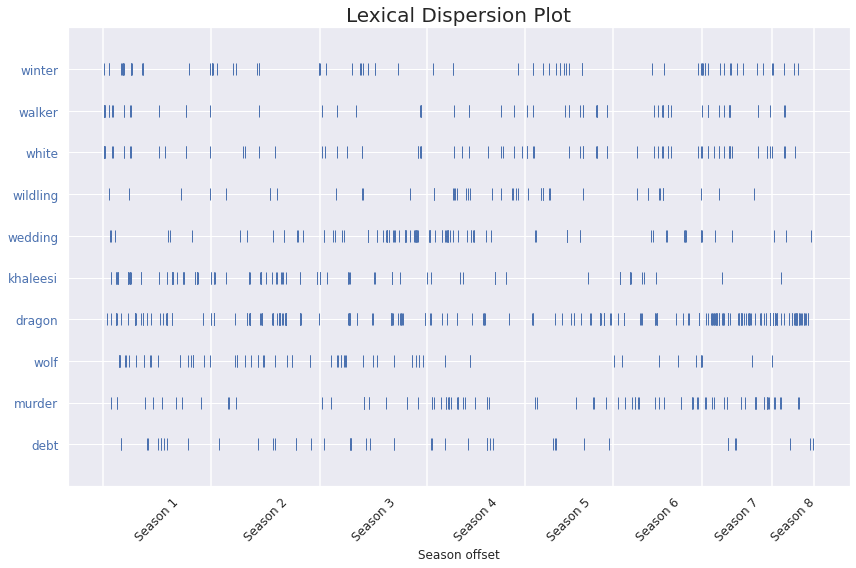

In [ ]:
plt.figure(figsize = (12,8))
dispersion_plot(all_words, ["winter","walker","white","wildling",'wedding','khaleesi', "dragon","wolf", "murder","debt"],
                    xticks = ticks, xlabels = labels, lines = vert_line)


Looking at the lexical dispersion plot above, the first word we chose was *winter*. This is due to the famous Stark house words being "Winter is coming" and we wanted to investigate how much this phrase was actually used. It appears *winter* is most used in the beginning and the end of the show. Only sorting for the word *winter* has the caveat though, that other common phrases such as *the long winter* are also represented here.

Another interesting comparison is the words *dragon* and *wolf*. Both the Targaryens and Starks are refered to as dragons and wolves respectivly but the Stark children also raise their own dire wolf throughout the show. The same can be said for Daenarys whose dragons are born in the end of season 1 and raised througout the show. In the beginning of the show, the wolves are more commonly mentioned compared to the ending where they are barely mentioned. The opposite holds true for *dragon* which is less mentioned in the beginning but mentioned more and more as the story unfolds. 

It can also be seen that the word *wedding* is mentioned most during season 3 and season 4. This holds true to the story as both Robb Stark, Joffrey Baratheon and Sansa Stark are all married during these seasons. 

<h2 align="center"> 4. Subconclusion </h2>

---

Through the use of wordclouds it was possible to dive into the words used by a few selected characters and allegiances, and the extracted words clearly did explain these characters and allegiances. The words did also correspond well with the biased image of the characters and allegiances. Further, through the TF-IDF analysis of the seasons, we could see that the theme clearly changes as the series progress, and this was further backed up by the dispersion plot. 

Lastly, by analysing the sentiment of the characters based on the dialogoue and wiki-pages that the dialogoue did contain larger variation in sentiment which would be expected as dialogoue would be expected to contain more polarizing words. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0aadd790-0254-407e-bf1a-a0259cad43c9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>